In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from renormalization import *

In [118]:
@njit(cache=True)
def G_r_prime(r, J):
    log_R_pp, log_R_pm = log_Rpp_Rpm(r, J)
    G_r = 0.5 * (log_R_pp + log_R_pm)
    return G_r


@njit(cache=True)
def G_prime(J):
    D = len(J) - 1
    r_max = (D - 2) // 3
    G_new = np.zeros(r_max + 1, dtype=np.float64)
    for r in range(1, r_max + 1):
        G_new[r] = G_r_prime(r, J)
    return G_new


def phi_from_G(J_init, max_steps=8):
    J = J_init.copy()
    phi = 0.0
    b = 3
    for k in range(max_steps):
        G_vec = G_prime(J)
        G_k = np.sum(G_vec)
        phi += (1 / 3**(k+1)) * G_k
        J = rg_step(J)
    return phi


def u_r(T, a, r_list, max_steps=8, R_final=3, dJ_rel=1e-3):
    J0 = 1 / T
    r_list = np.array(r_list, dtype=np.int64)

    D_init = required_initial_max_distance(R_final, max_steps)
    J_base = build_J(J0, a, D_init)

    results = {}
    for r in r_list:
        J_r0 = J_base[r]
        dJ = dJ_rel * abs(J_r0) if J_r0 != 0 else dJ_rel

        Jp = J_base.copy()
        Jp[r] = J_r0 + dJ

        phi_p = phi_from_G(Jp, max_steps=max_steps)
        phi = phi_from_G(J_base, max_steps=max_steps)
        dphi_dJr = abs(phi_p - phi) / dJ
        results[r] = dphi_dJr / D_init
    return results

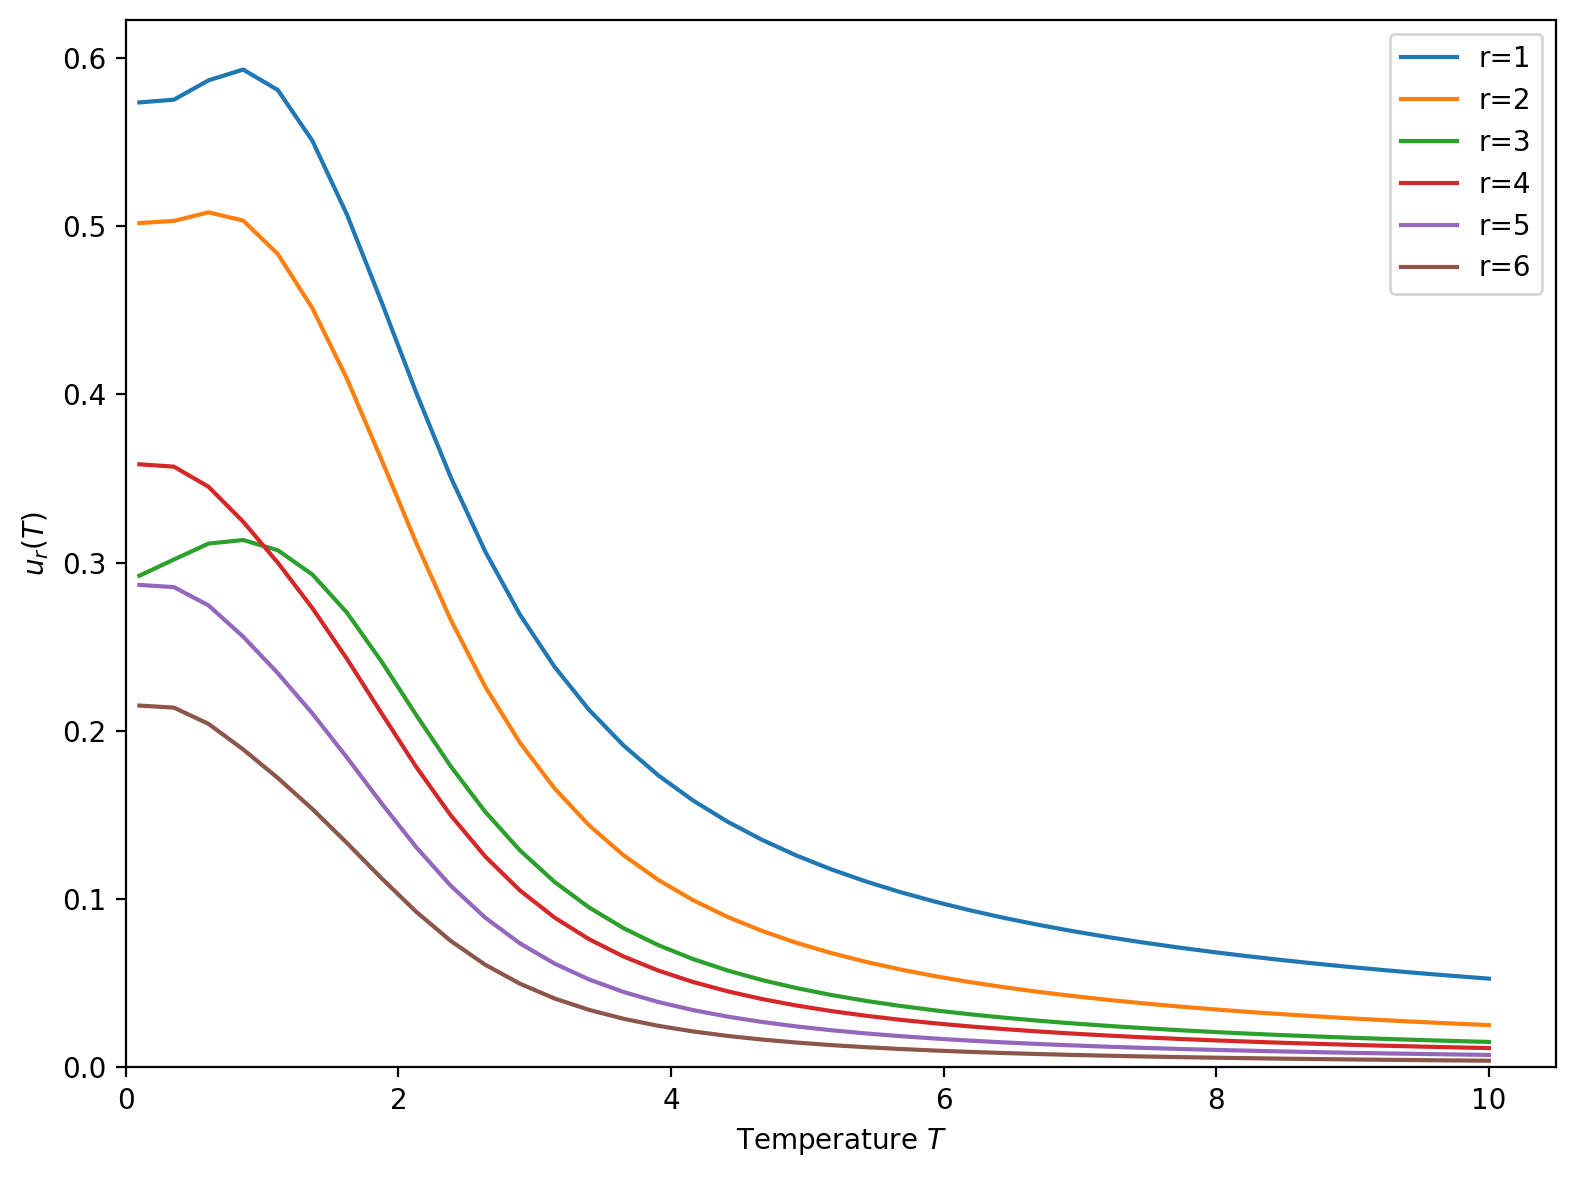

In [125]:
a = 1.
r_values = [1, 2, 3, 4, 5, 6]
T_values = np.linspace(0.1, 10, 40)
u_results = {r: [] for r in r_values}

for T in T_values:
    ur_dict = u_r(T, a, r_values, max_steps=2, R_final=6, dJ_rel=1e-3)
    for r in r_values:
        u_results[r].append(ur_dict[r])

plt.figure(figsize=(8, 6))
for r in r_values:
    plt.plot(T_values, u_results[r], label=f"r={r}")
plt.xlim(0, None)
plt.ylim(0, None)
plt.xlabel("Temperature $T$")
plt.ylabel("$u_r(T)$")
plt.legend()
plt.tight_layout()
plt.show()

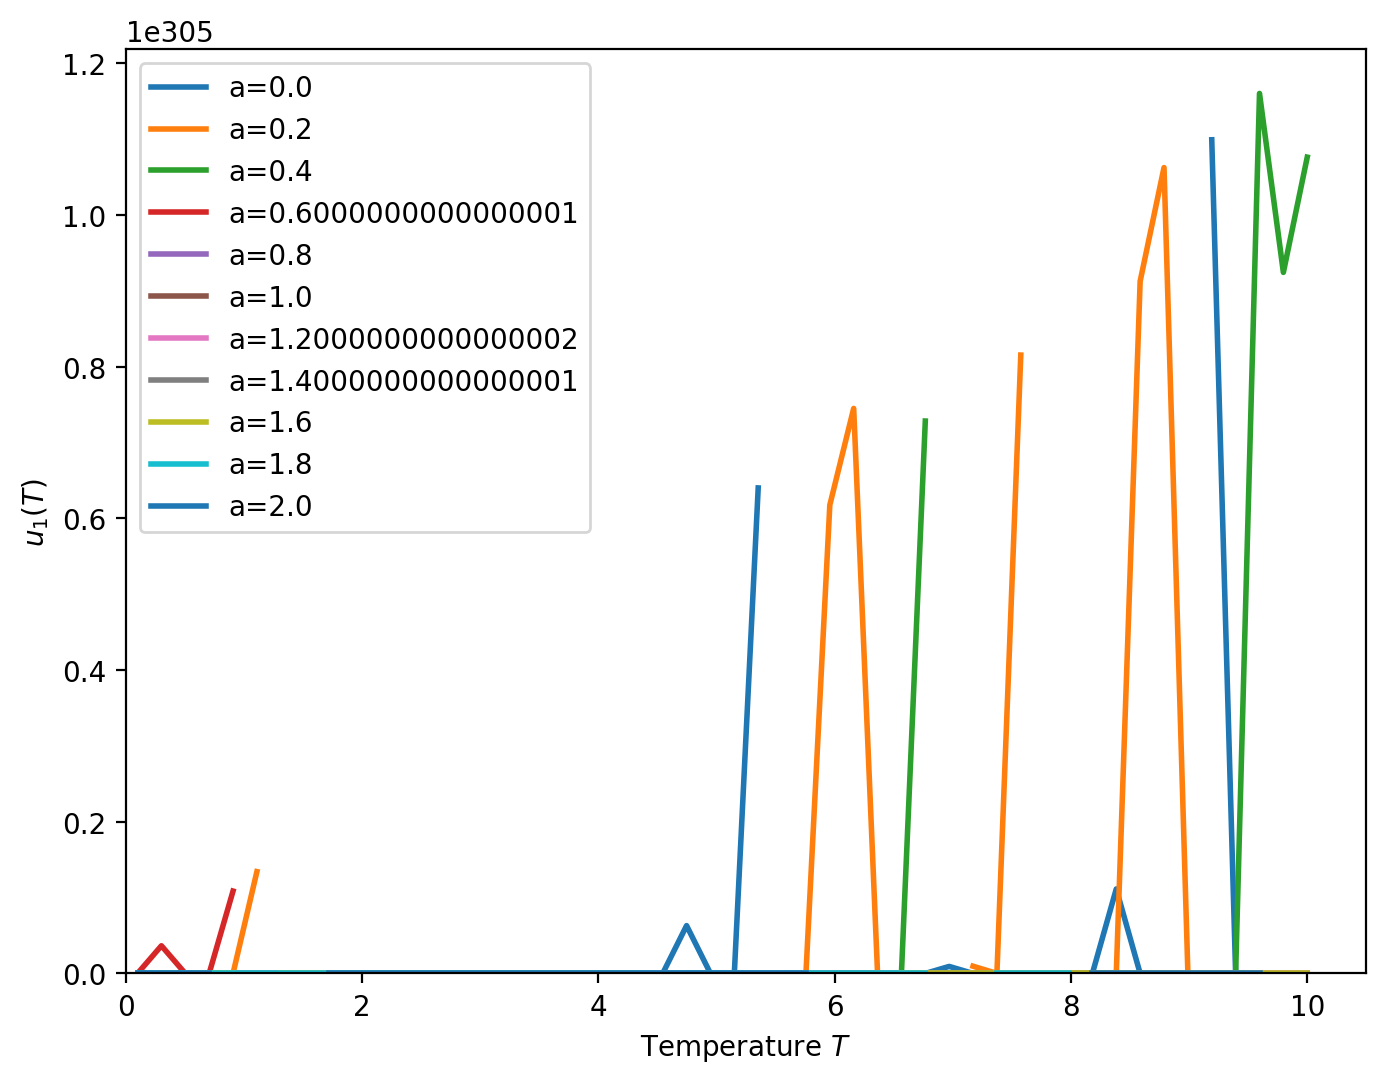

In [5]:
r_values = [1]
a_values = np.linspace(0, 2, 11)
T_values = np.linspace(0.1, 10, 50)

u_results = {a: {r: [] for r in r_values} for a in a_values}

for a in a_values:
    for T in T_values:
        ur_dict = u_r(T, a, r_values, max_steps=6, R_final=6, dJ_rel=1e-3)
        for r in r_values:
            u_results[a][r].append(ur_dict[r])


for r in r_values:
    plt.figure(figsize=(8, 6))
    for a in a_values:
        plt.plot(T_values, u_results[a][r], label=f"a={a}", lw=2)
    plt.xlim(0, None)
    plt.ylim(0, None)
    plt.xlabel("Temperature $T$")
    plt.ylabel(f"$u_{r}(T)$")
    plt.legend()
    plt.show()